# Spiking data and population burst events 


In [3]:
# %matplotlib notebook

## Read spike data 

### Spike data was stored in a MATLAB data structure and here we need to retrieve it. It contains information on spike timing, spatial tuning, stability, animal velocity at spike time, etc

### Cluster Quality (L-ratios)

In [20]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import h5py
import mplcursors
from learned_tuning.Bayesian_decoder import Bayesian_decoder
from learned_tuning.learned_tuning import calculate_learned_tuning, calculate_place_field_fidelity_of_learned_tuning

data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.clusterQuality.mat'
file_path = os.path.join(data_dir, filename)


mat_file = scipy.io.loadmat(file_path)

# Access data structure

num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

L_ratios = list()
for shank in range(num_shanks):    
    curr_shank_L_ratios = dict()
    curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
    curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
    
    L_ratios.append(curr_shank_L_ratios)

#####  Plot the L-ratios for the example shank

3.415756102675768e-07 0.00022119372263319223 0.013073590387247244


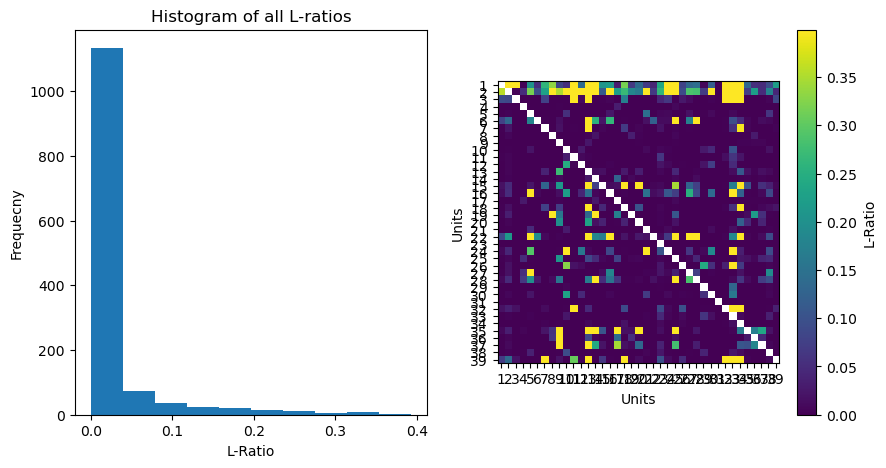

In [5]:
L_ratios_example_shank = L_ratios[4]["L_ratios"]

num_units, num_units = L_ratios_example_shank.shape

# Flatten the array to create a 1D array of all values
all_L_ratios = L_ratios_example_shank.flatten()

# Calculate the 5th and 95th percentiles. 
vmin, vmax = np.nanpercentile(all_L_ratios, [5, 95])

p25, median, p75 = np.nanpercentile(all_L_ratios, [25, 50, 75])

print(p25, median, p75)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))


# Plot a histogram of all L-Ratios
all_L_ratios_filtered = all_L_ratios[(all_L_ratios >= vmin) & (all_L_ratios <= vmax)]

ax1.hist(all_L_ratios_filtered)
ax1.set_title('Histogram of all L-ratios')
ax1.set_xlabel('L-Ratio')
ax1.set_ylabel('Frequecny')


# Display the L-Ratios as an image using imshow()


img = ax2.imshow(L_ratios_example_shank, vmin = vmin, vmax = vmax) # limit the range in color code to 5 and 95 percentiles
cb = fig.colorbar(img, ax = ax2, label = 'L-Ratio')

ax2.set_xticks(range(num_units))
ax2.set_yticks(range(num_units))

ax2.set_xticklabels([str(i+1) for i in range(num_units)])
ax2.set_yticklabels([str(i+1) for i in range(num_units)])


ax2.set_xlabel('Units')
ax2.set_ylabel('Units')



plt.show()

##### Calculate how many pairs satisfy the criterion L-Ratio < 1e-3 

In [6]:
L_ratio_thresh = 1e-3
small_L_ratio_percentage = all_L_ratios[all_L_ratios <= L_ratio_thresh].size/all_L_ratios.size
print(small_L_ratio_percentage*100)

55.818540433925044


### Place Fields

148 95


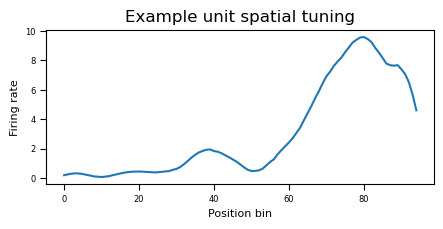

position bin with the peak firing rate is 81


In [7]:
data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.spikes_for_python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)
spikes_pyr = mat_file["spikes_pyr"]


#### Extracting all place fields from the imported .mat file
spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

num_units    = spatial_tuning_smoothed[0].shape[0]
num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

print(num_units, num_pos_bins)

spikes = []; # spike data and place field info of each unit

# attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
running_directions = {'LR', 'RL', 'uni'}
other_attributes   = {'spike_times', 'shank_id','cluster_id'}

for unit in range(num_units):
    
    # Create dictionaries for each unit and store the matrices
    
    unit_spikes = dict()
    
    unit_spikes['place_fields']  = {}
    unit_spikes['peak_pos_bins'] = {}
    for direction in running_directions:
        unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
        unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

    unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
    unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
    unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        
    spikes.append(unit_spikes) 
    
# pltttong the place field corresponding to a running direction for an example unit
example_unit = 5

fig, ax = plt.subplots(figsize=(5, 2), dpi=100)

ax.plot(spikes[example_unit]['place_fields']['uni'])

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) 
ax.set_xlabel("Position bin", fontsize=8)
ax.set_ylabel("Firing rate", fontsize=8)
plt.title("Example unit spatial tuning")

# Set up the cursor to display values on click
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(
    f'x={sel.target[0]:.2f}, y={sel.target[1]:.2f}'))

plt.show()

print(f"position bin with the peak firing rate is {spikes[example_unit]['peak_pos_bins']['uni']}")


In [8]:
data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.fileInfo_for_python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)
session_info = mat_file["fileInfo"]

epochs = session_info["behavior"][0][0][0][0]["time"]
print(epochs)

[[    0.     18079.5   ]
 [18079.5    20147.    ]
 [20147.     34861.1032]]


#### Plot place fields sorted based on the peak firing rate locations 


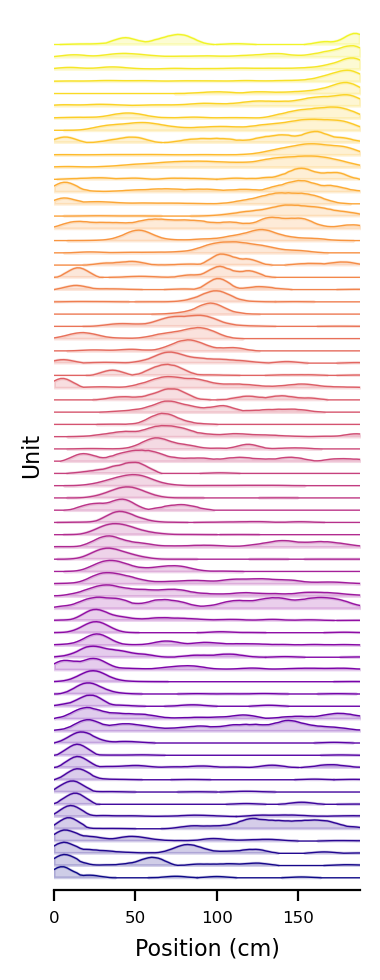

In [9]:
# place fields in RL running direction

place_fields_RL = []
peak_pos_bins_RL = []
for unit in range(num_units):
    place_fields_RL.append(spikes[unit]['place_fields']['RL'])    
    peak_pos_bins_RL.append(spikes[unit]['peak_pos_bins']['RL'])
    
place_fields_RL = np.array(place_fields_RL)
peak_pos_bins_RL = np.array(peak_pos_bins_RL)

peak_place_field_sorting_indices = np.argsort(peak_pos_bins_RL)


# Create an array of original row indices
original_row_indices = np.arange(num_units)


place_fields_sorted = place_fields_RL[peak_place_field_sorting_indices]
original_row_indices_sorted = original_row_indices[peak_place_field_sorting_indices]


# Find the maximum value in each row of the matrix
max_vals = np.amax(place_fields_sorted, axis=1)

# Create a boolean mask for rows with a maximum value >= 1
mask = max_vals >= 1

# Select the rows that you want to plot
selected_rows = place_fields_sorted[mask]
selected_row_indices = original_row_indices_sorted[mask]

# Normalize each curve to a maximum of 1
selected_rows = selected_rows / np.amax(selected_rows, axis=1, keepdims=True) * 0.9

# Define the x-axis values (e.g. position bins)
x = np.arange(num_pos_bins)

# Create the plot
fig, ax = plt.subplots(figsize=(2, 5), dpi=200)

# Set the colormap to "viridis"
cmap = plt.get_cmap("plasma")

# Loop over each selected row of the matrix and plot a filled curve
for i in range(selected_rows.shape[0]):
    y = selected_rows[i]  # Select the i-th row of the matrix
    ax.fill_between(x, y + i, i, where=y > 0, interpolate=True, alpha=0.2, color=cmap(i/selected_rows.shape[0]))
    ax.plot(x, y + i, color=cmap(i/selected_rows.shape[0]), alpha=1, linewidth=0.5)

# Set the y-axis limits and labels
ax.set_ylim(-1, selected_rows.shape[0] + 1)
ax.set_yticks(np.arange(selected_rows.shape[0]))
ax.set_yticklabels(np.arange(selected_rows.shape[0]) + 1)

# Set the x-axis limits and labels
ax.set_xlim(x[0], x[-1])
ax.set_xlabel("Position (cm)", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
ax.set_yticks([]) # set y-axis ticks to an empty list
ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks


# Set x-axis tick labels in intervals of 10 and multiply by 2
new_ticks = [int(bin)*2 for bin in range(num_pos_bins)[::25]]
ax.set_xticks(range(num_pos_bins)[::25])
ax.set_xticklabels(new_ticks)

# Remove the box
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add white space
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
fig.tight_layout()

# Show the plot
plt.show()

# fig.savefig("myplot.pdf", format="pdf")

### Population burst events (PBEs)

In [10]:
data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013';
filename = 'Achilles_10252013.PBEInfo_replayScores.mat'

file_path = os.path.join(data_dir, filename)
f = h5py.File(file_path, "r")

PBEInfo = f['PBEInfo_replayScores']

print(list(PBEInfo.keys()))

['MUAWave', 'SWA', 'begPosition', 'brainState', 'coveredLen', 'duration', 'emg', 'endPosition', 'endT', 'epoch', 'fr_1msbin', 'fr_20msbin', 'jumpDist', 'linearPos', 'n', 'nFiringUnits', 'nTimeBins', 'onlyLineElements', 'peakMUA', 'peakRippleA', 'peakT', 'postMat_nonNorm', 'posteriorProbMat', 'radonIntegral', 'replayOrderScore', 'replayOrderScore_prctile', 'rippleWave', 'rt_ds', 'rt_pf', 'rt_ts', 'rt_ui', 'sessionName', 'startT', 'thetaRatio', 'velocity', 'vmaxsign', 'wc_ds', 'wc_pf', 'wc_ts', 'wc_ui', 'weightedCorr']


#### Store the population burst events in a new variable 


In [11]:
# Define a list of PBE dictionaries
PBEs = []

# Define the number of PBEs and matrix types
num_PBEs = PBEInfo["fr_1msbin"].shape[0]

attributes = list(PBEInfo.keys())

# Loop over the PBEs and create a dictionary for each one
for pbe in range(num_PBEs):   
    # Create a dictionary for the PBE and store the matrices
    PBE_dict = {}
    for attr in attributes:
        ref = PBEInfo[attr][pbe][0]
        obj = f[ref] 
        PBE_dict[attr] = np.array(obj) 

    PBEs.append(PBE_dict)

#### Let's see if we can do decode position during the PBEs using the Bayesian decoding algorithm and place fields

Text(0.5, 1.0, 'posterior_Matlab')

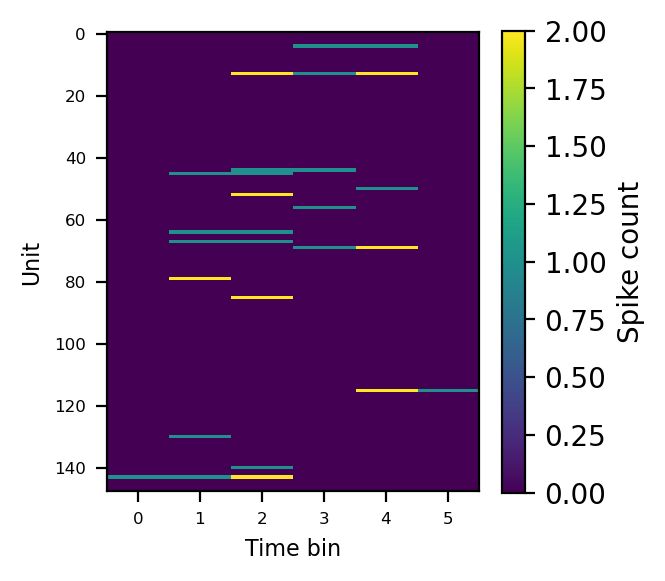

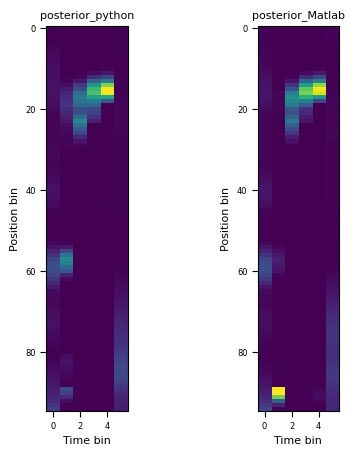

In [21]:
def normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_sum = np.sum(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_sum[np.newaxis, :]
    
    return normalized_matrix



# spike count per 20 ms time bin for an example event
# example_unit = int(input("Enter the example unit: "))
example_unit = 5

PBE_each_bin_spike_counts = PBEs[example_unit]["fr_20msbin"].transpose()

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

img = ax.imshow(PBE_each_bin_spike_counts, aspect = 0.05)

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax.set_xlabel("Time bin", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
cb = fig.colorbar(img, ax = ax, label = 'Spike count')


# Let's perfrom Bayesian decoding on the example PBE
# Decode the position given the place fields in each direction and then marginalize 

# place fields in LR running direction
place_fields_LR = []
for unit in range(num_units):
    place_fields_LR.append(spikes[unit]['place_fields']['LR'])    
place_fields_LR = np.array(place_fields_LR)

place_fields_LR[place_fields_LR == 0] = 1e-4


# place fields in RL running direction
place_fields_RL = []
for unit in range(num_units):
    place_fields_RL.append(spikes[unit]['place_fields']['RL'])
place_fields_RL = np.array(place_fields_RL)

place_fields_RL[place_fields_RL == 0] = 1e-4


time_bin_duration = 0.02; # in seconds
num_position_bins = place_fields_LR.shape[1] 
num_time_bins = PBE_each_bin_spike_counts.shape[1]


posterior_LR = Bayesian_decoder(PBE_each_bin_spike_counts, place_fields_LR, time_bin_duration) # RL direction
posterior_RL = Bayesian_decoder(PBE_each_bin_spike_counts, place_fields_RL, time_bin_duration) # LR direction

posterior = posterior_LR + posterior_RL
posterior_normalized = normalize_columns(posterior)


# Eliminate the posteriors calculated in time bins with no firing
posterior_normalized[:, np.sum(PBE_each_bin_spike_counts, axis = 0) == 0] = 0;



# Let's compare the posteriors with the ones calculated in matlab
posterior_calculated_matlab = PBEs[example_unit]["posteriorProbMat"]
posterior_calculated_matlab = np.transpose(posterior_calculated_matlab)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 5), dpi = 100)

img = ax1.imshow(posterior_normalized, vmin = 0, vmax = 0.23, aspect = 0.3) 

ax1.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax1.set_xlabel("Time bin", fontsize=8)
ax1.set_ylabel("Position bin", fontsize=8)
ax1.set_title("posterior_python", fontsize=8)
# cb = fig.colorbar(img, ax = ax1, label = 'Posterior probability')


img = ax2.imshow(posterior_calculated_matlab, vmin = 0, vmax = 0.23, aspect = 0.3)

ax2.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax2.set_xlabel("Time bin", fontsize=8)
ax2.set_ylabel("Position bin", fontsize=8)
ax2.set_title("posterior_Matlab", fontsize=8)
# cb = fig.colorbar(img, ax = ax2, label = 'Posterior probability')


### Learned tunings

In [18]:
# Subselect PBEs for calculation of learned tunings
# Maze Epoch

num_PBEs = len(PBEs)
PBEs_peak_time = np.zeros((num_PBEs, 1))

for pbe in range(num_PBEs):
    PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]

select_IDX = np.where((PBEs_peak_time >= epochs[2,0]) & (PBEs_peak_time <= epochs[2,0]+3600))[0] # the first hour of POST
PBEs_POST = np.take(PBEs, select_IDX)


time_bin_duration=0.02
learned_tunings = calculate_learned_tuning(PBEs_POST, spikes, L_ratios, time_bin_duration)

In [ ]:
# To check if the Python code works well, we compare the learned tunings with the one calcualted using MATLAB

data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.assemblyTunings_allPBEs_for_Python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)

epoch = "post"
learned_tunings_post_matlab = mat_file["assemblyTunings"][epoch][0][0][0]["data"][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 100)

normalized_LTs = learned_tunings_post_matlab / np.max(learned_tunings_post_matlab, axis=1, keepdims=True)
ax1.imshow(normalized_LTs[selected_row_indices, :], origin='lower')
ax1.set_title("POST learend tuning MATLAB")

normalized_LTs = learned_tunings / np.max(learned_tunings, axis=1, keepdims=True)
ax2.imshow(normalized_LTs[selected_row_indices, :], origin='lower')
ax2.set_title("POST learend tuning Python")

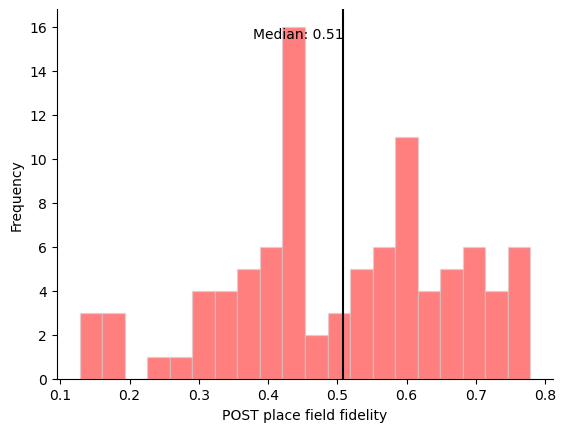

In [24]:
# place fields by pooling spikes across both running directions
place_fields_uni = []
for unit in range(num_units):
    place_fields_uni.append(spikes[unit]['place_fields']['uni'])
place_fields_uni = np.array(place_fields_uni)

place_fields_uni[place_fields_uni == 0] = 1e-4

learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr, p_value = calculate_place_field_fidelity_of_learned_tuning(learned_tunings, place_fields_uni, 20)


# plot the distribution of the learned tuning place field pearson correlation
fig, ax = plt.subplots()
n, bins, patches = ax.hist(learned_tuning_place_field_pearson_corr, bins=20, edgecolor='lightgray', alpha=0.5, color='r')

# Calculate and plot nanmedian
nanmedian = np.nanmedian(learned_tuning_place_field_pearson_corr)
ax.axvline(nanmedian, color='black', linestyle='-')
ax.text(nanmedian, n.max(), f'Median: {nanmedian:.2f}', ha='right', va='top')

# Set plot title and labels
ax.set_xlabel('POST place field fidelity')
ax.set_ylabel('Frequency')

# Remove box around figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Show the plot
plt.show()

### How many ripples are needed to calculate the learned tunings


In [28]:
import random

num_iterations = 1  # Number of iterations
step_size = 100
random.seed(100)  # Set random seed for reproducibility
time_bin_duration=0.02

learned_tunings_PBE_subsets_diff_sizes = {}  # Use dictionary to store results by subset size
median_LT_PF_pearson_corr_diff_sizes = {}

# Loop for each iteration
for i in range(num_iterations):
    print(f"Iteration {i+1}")
    
    subset_size = 100  # Reset subset size to 0 at the beginning of each iteration
    
    # Perform calculation for each PBE subset size
    while subset_size < 500:  #len(PBEs_POST):

        print(f"subset_size =  {subset_size+1}")

        subset_indices = random.sample(range(len(PBEs_POST)), subset_size + 1)  # Randomly sample subset indices
        PBE_subset = [PBEs_POST[i] for i in subset_indices]  # Get the randomized subset of PBEs

        # Execute base process on the PBE subset
        
        learned_tunings = calculate_learned_tuning(PBE_subset, spikes, L_ratios, time_bin_duration)
        learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr, _ = calculate_place_field_fidelity_of_learned_tuning(learned_tunings, place_fields_uni, 20)

        # Store results in dictionary by subset size
        if subset_size not in learned_tunings_PBE_subsets_diff_sizes:
            learned_tunings_PBE_subsets_diff_sizes[subset_size] = []
        if subset_size not in median_LT_PF_pearson_corr_diff_sizes:
            median_LT_PF_pearson_corr_diff_sizes[subset_size] = []
        learned_tunings_PBE_subsets_diff_sizes[subset_size].append(learned_tuning_place_field_pearson_corr)
        median_LT_PF_pearson_corr_diff_sizes[subset_size].append(median_LT_PF_pearson_corr)

        subset_size += step_size  # Increment the subset size by step_size


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 22)

In [26]:
median_LT_PF_pearson_corr_diff_sizes

{0: [{'data': 0.5085115553328116,
   'PF_unit_IDX_shuffle': array([0.25683452, 0.32452219, 0.26359485, 0.28715226, 0.2830989 ,
          0.31380474, 0.25115429, 0.25938302, 0.26345924, 0.30715527,
          0.25771179, 0.29976223, 0.25174252, 0.27012951, 0.2797552 ,
          0.2599104 , 0.26833985, 0.28996776, 0.29872704, 0.30168664])}],
 100: [{'data': 0.5085115553328116,
   'PF_unit_IDX_shuffle': array([0.27915081, 0.26326616, 0.30519635, 0.27522035, 0.25368095,
          0.2487999 , 0.2604148 , 0.28661707, 0.24110499, 0.2917134 ,
          0.25362197, 0.24107993, 0.27400511, 0.27977905, 0.25337885,
          0.24833767, 0.2505993 , 0.26376432, 0.27048648, 0.27486254])}],
 200: [{'data': 0.5085115553328116,
   'PF_unit_IDX_shuffle': array([0.30605703, 0.26175654, 0.30823984, 0.28475246, 0.2152643 ,
          0.28426418, 0.2593803 , 0.30722833, 0.25778267, 0.28039222,
          0.30466206, 0.27983008, 0.25362812, 0.28898851, 0.26675514,
          0.30486757, 0.26494048, 0.285522  , 0